<a href="https://colab.research.google.com/github/dksifoua/Neural-Machine-Translation/blob/master/5%20-%20SeqToSeq%20Model%20with%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Oct  7 23:49:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 40%   60C    P5    11W / 180W |      1MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dependencies

In [2]:
# !pip install tqdm --upgrade >> /dev/null 2>&1
# !pip install torchtext --upgrade >> /dev/null 2>&1
# !pip install spacy --upgrade >> /dev/null 2>&1
# !python -m spacy download de >> /dev/null 2>&1
# !python -m spacy download en >> /dev/null 2>&1

In [3]:
import tqdm
import spacy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Dataset, Example, Field
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score
from torchtext.datasets import Multi30k

In [4]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 546
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## Prepare data

In [5]:
%%time
DE = Field(init_token='<sos>', eos_token='<eos>', lower=True, tokenize='spacy', tokenizer_language='de', batch_first=True)
EN = Field(init_token='<sos>', eos_token='<eos>', lower=True, tokenize='spacy', tokenizer_language='en', batch_first=True)
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),  fields=(DE, EN), root='./data')
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

train set size: 29,000
valid set size: 1,014
test set size: 1,000
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
CPU times: user 9.51 s, sys: 276 ms, total: 9.79 s
Wall time: 9.8 s


***Build vocabularies***

In [6]:
%%time
MIN_COUNT = 2
DE.build_vocab(train_data, min_freq=MIN_COUNT)
EN.build_vocab(train_data, min_freq=MIN_COUNT)
print(f'Length of DE vocabulary: {len(DE.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of DE vocabulary: 7,854
Length of EN vocabulary: 5,893
CPU times: user 439 ms, sys: 0 ns, total: 439 ms
Wall time: 439 ms


## Modeling

***Multi Head Attention Layer***

In [7]:
class MultiHeadAttentionLayer(nn.Module):

    def __init__(self, d_model, n_heads):
        super(MultiHeadAttentionLayer, self).__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        :param Tensor[batch_size, q_len, d_model] query
        :param Tensor[batch_size, k_len, d_model] key
        :param Tensor[batch_size, v_len, d_model] value
        :param Tensor[batch_size, ..., k_len] mask
        :return Tensor[batch_size, q_len, d_model] context
        :return Tensor[batch_size, n_heads, q_len, k_len] attention_weights
        """
        Q = self.fc_q(query) # [batch_size, q_len, d_model]
        K = self.fc_k(key) # [batch_size, k_len, d_model]
        V = self.fc_v(value) # [batch_size, v_len, d_model]

        Q = Q.view(Q.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, q_len, head_size]
        K = K.view(K.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, k_len, head_size]
        V = V.view(V.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, v_len, head_size]

        scores = torch.matmul(Q, K.transpose(-1, -2)) # [batch_size, n_heads, q_len, k_len]
        scores = scores / torch.sqrt(torch.FloatTensor([self.head_size]).to(Q.device))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e18)
        attention_weights = F.softmax(scores , dim=-1) # [batch_size, n_heads, q_len, k_len]                
        
        context = torch.matmul(attention_weights, V) # [batch_size, n_heads, q_len, v_len]
        context = context.permute(0, 2, 1, 3).contiguous() # [batch_size, q_len, n_heads, v_len]
        context = context.view(context.size(0), -1, self.d_model)
        context = self.fc_o(context) # [batch_size, q_len, d_model]

        return context, attention_weights

***Position-Wise Feed-Forward Layer***

In [8]:
class PositionWiseFeedForwardLayer(nn.Module):
    
    def __init__(self, d_model, hidden_size):
        super(PositionWiseFeedForwardLayer, self).__init__()
        self.d_model = d_model
        self.hidden_size = hidden_size
        self.fc_in = nn.Linear(d_model, hidden_size)
        self.fc_ou = nn.Linear(hidden_size, d_model)
        
    def forward(self, inputs):
        """
        :param Tensor[batch_size, seq_len, d_model] inputs
        :return Tensor[batch_size, seq_len, d_model] outputs
        """
        outputs = F.relu(self.fc_in(inputs)) # [batch_size, seq_len, hidden_size]
        return self.fc_ou(outputs) # [batch_size, seq_len, d_model]

***Positional Encoding Layer***

In [9]:
class PositionalEncodingLayer(nn.Module):
    
    def __init__(self, d_model, max_len=100):
        super(PositionalEncodingLayer, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
    
    def get_angles(self, positions, indexes):
        d_model_tensor = torch.FloatTensor([[self.d_model]]).to(positions.device)
        angle_rates = torch.pow(10000, (2 * (indexes // 2)) / d_model_tensor)
        return positions / angle_rates

    def forward(self, input_sequences):
        """
        :param Tensor[batch_size, seq_len] input_sequences
        :return Tensor[batch_size, seq_len, d_model] position_encoding
        """
        positions = torch.arange(input_sequences.size(1)).unsqueeze(1).to(input_sequences.device) # [seq_len, 1]
        indexes = torch.arange(self.d_model).unsqueeze(0).to(input_sequences.device) # [1, d_model]
        angles = self.get_angles(positions, indexes) # [seq_len, d_model]
        angles[:, 0::2] = torch.sin(angles[:, 0::2]) # apply sin to even indices in the tensor; 2i
        angles[:, 1::2] = torch.cos(angles[:, 1::2]) # apply cos to odd indices in the tensor; 2i
        position_encoding = angles.unsqueeze(0).repeat(input_sequences.size(0), 1, 1) # [batch_size, seq_len, d_model]
        return position_encoding

(64, 50, 512)


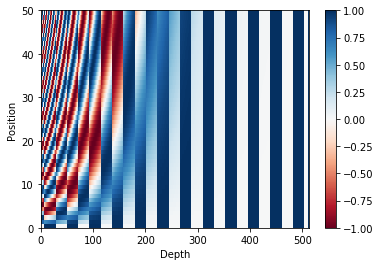

In [10]:
pos_encoding = PositionalEncodingLayer(d_model=512)(torch.randint(100, size=(64, 50))).numpy()
print(pos_encoding.shape)
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

***Encoder Block Layer***

In [11]:
class EncoderBlockLayer(nn.Module):
    
    def __init__(self, d_model, n_heads, hidden_size, dropout):
        super(EncoderBlockLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.position_wise_feed_forward_layer = PositionWiseFeedForwardLayer(d_model=d_model, hidden_size=hidden_size)
        self.position_wise_feed_forward_layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, src_inputs, src_mask):
        """
        :param Tensor[batch_size, src_len, d_model] src_inputs
        :param Tensor[batch_size,  src_len] src_mask
        :return Tensor[batch_size, src_len, d_model] outputs
        """
        context, _ = self.multi_head_attention_layer(query=src_inputs, key=src_inputs, value=src_inputs, mask=src_mask)
        context = self.multi_head_attention_layer_norm(self.dropout(context) + src_inputs)
        
        outputs = self.position_wise_feed_forward_layer(context)
        outputs = self.position_wise_feed_forward_layer_norm(self.dropout(outputs) + context)
        
        return outputs

***Decoder Block Layer***

In [12]:
class DecoderBlockLayer(nn.Module):
    
    def __init__(self, d_model, n_heads, hidden_size, dropout):
        super(DecoderBlockLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.mask_multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.mask_multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.position_wise_feed_forward_layer = PositionWiseFeedForwardLayer(d_model=d_model, hidden_size=hidden_size)
        self.position_wise_feed_forward_layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, dest_inputs, src_encoded, dest_mask, src_mask):
        """
        :param Tensor[batch_size, dest_len, d_model] dest_inputs
        :param Tensor[batch_size, src_len, d_model] src_encoded
        :param Tensor[batch_size,  dest_len] dest_mask
        :param Tensor[batch_size,  src_len] src_mask
        :return Tensor[batch_size, dest_len, d_model] outputs
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        masked_context, _ = self.mask_multi_head_attention_layer(query=dest_inputs, key=dest_inputs, value=dest_inputs, mask=dest_mask)
        masked_context = self.mask_multi_head_attention_layer_norm(self.dropout(masked_context) + dest_inputs)
        
        context, attention_weights = self.multi_head_attention_layer(query=masked_context, key=src_encoded, value=src_encoded, mask=src_mask)
        context = self.multi_head_attention_layer_norm(self.dropout(context) + masked_context)
        
        outputs = self.position_wise_feed_forward_layer(context)
        outputs = self.position_wise_feed_forward_layer_norm(self.dropout(outputs) + context)
        
        return outputs, attention_weights

***Encoder Layer***

In [13]:
class EncoderLayer(nn.Module):
    
    def __init__(self, vocab_size, max_len, d_model, n_heads, hidden_size, dropout, n_layers):
        super(EncoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.n_layers = n_layers
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncodingLayer(d_model=d_model, max_len=max_len)
        self.encoder_block_layers = nn.ModuleList([EncoderBlockLayer(d_model=d_model, n_heads=n_heads, hidden_size=hidden_size,
                                                                     dropout=dropout) for _ in range(n_layers)])
    
    def forward(self, src_sequences, src_mask):
        """
        :param Tensor[batch_size, src_len] src_sequences
        :param Tensor[batch_size, src_len] src_mask
        :return Tensor[batch_size, src_len, d_model] outputs
        """
        token_embedded = self.token_embedding(src_sequences) # [batch_size, src_len, d_model]
        position_encoded = self.position_encoding(src_sequences) # [batch_size, src_len, d_model]
        outputs = self.dropout(token_embedded) + position_encoded # [batch_size, src_len, d_model]
        for layer in self.encoder_block_layers:
            outputs = layer(src_inputs=outputs, src_mask=src_mask) # [batch_size, src_len, d_model]
        return outputs

***Decoder Layer***

In [14]:
class DecoderLayer(nn.Module):
    
    def __init__(self, vocab_size, max_len, d_model, n_heads, hidden_size, dropout, n_layers):
        super(DecoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.n_layers = n_layers
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncodingLayer(d_model=d_model, max_len=max_len)
        self.decoder_block_layers = nn.ModuleList([DecoderBlockLayer(d_model=d_model, n_heads=n_heads, hidden_size=hidden_size, dropout=dropout) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, vocab_size)
    
    def forward(self, dest_sequences, src_encoded, dest_mask, src_mask):
        """
        :param Tensor[batch_size, dest_len] dest_sequences
        :param Tensor[batch_size, src_len, d_model] src_encoded
        :param Tensor[batch_size, dest_len, d_model] dest_mask
        :param Tensor[batch_size, src_len, d_model] src_mask
        :return Tensor[batch_size, dest_len, vocab_size] logits
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        token_embedded = self.token_embedding(dest_sequences) # [batch_size, dest_len, d_model]
        position_encoded = self.position_encoding(dest_sequences) # [batch_size, dest_len, d_model]
        outputs = self.dropout(token_embedded) + position_encoded # [batch_size, dest_len, d_model]
        for layer in self.decoder_block_layers:
            outputs, attention_weights = layer(dest_inputs=outputs, src_encoded=src_encoded, dest_mask=dest_mask, src_mask=src_mask)
        logits = self.fc(outputs)
        return logits, attention_weights

***Transformer Model***

In [15]:
class Transformer(nn.Module):
    
    def __init__(self, encoder, decoder, src_pad_index, dest_pad_index):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_index = src_pad_index
        self.dest_pad_index = dest_pad_index

    def make_src_mask(self, src_sequences):
        """Mask <pad> tokens.
        :param Tensor[batch_size, src_len] src_sequences
        :return Tensor[batch size, 1, 1, src len] src_mask
        """        
        src_mask = (src_sequences != self.src_pad_index).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_dest_mask(self, dest_sequences):
        """Mask <pad> tokens and futur tokens as well.
        :param Tensor[batch_size, dest_len] dest_sequences
        :return tensor[batch_size, 1, dest_len, dest_len] dest_mask
        """
        mask = (dest_sequences != self.dest_pad_index).unsqueeze(1).unsqueeze(2) # [batch size, 1, 1, trg len]
        sub_mask = torch.tril(torch.ones((dest_sequences.size(1), dest_sequences.size(1))).to(dest_sequences.device)).bool() # [trg len, trg len]        
        return mask & sub_mask
    
    def forward(self, src_sequences, dest_sequences):
        """
        :param Tensor[batch_size, src_len] src_sequences
        :param Tensor[batch_size, dest_len] dest_sequences
        :return Tensor[batch_size, dest_len, vocab_size] logits
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        src_mask, dest_mask = self.make_src_mask(src_sequences), self.make_dest_mask(dest_sequences)
        src_encoded = self.encoder(src_sequences=src_sequences, src_mask=src_mask)
        logits, attention_weights = self.decoder(dest_sequences=dest_sequences, src_encoded=src_encoded, dest_mask=dest_mask, src_mask=src_mask)
        return logits, attention_weights

***Training routines***

In [16]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [17]:
def accuracy(outputs, target_sequences, k=5):
    """ Calculate Top-k accuracy
    :param Tensor[batch_size, dest_seq_len, vocab_size] outputs
    :param Tensor[batch_size, dest_seq_len] target_sequences
    :return float Top-k accuracy
    """
    # print([*map(lambda token: EN.vocab.itos[token], outputs.argmax(dim=-1)[0].tolist())])
    # print([*map(lambda token: EN.vocab.itos[token], target_sequences[0].tolist())])
    # print("="*100)
    batch_size = target_sequences.size(0)
    _, indices = outputs.topk(k, dim=2, largest=True, sorted=True) # [batch_size, dest_seq_len, 5]
    correct = indices.eq(target_sequences.unsqueeze(-1).expand_as(indices))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / indices.numel())

In [18]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
    
    def train_step(self, loader, epoch, grad_clip):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, batch in progress_bar:
            src, trg = batch.src, batch.trg
            self.optimizer.zero_grad()
            logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
            loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
            self.optimizer.step()
            loss_tracker.update(loss.item())
            acc_tracker.update(accuracy(logits, trg[:, 1:]))
            loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_:.3f} -     ppl: {ppl_:.3f} -     acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def validate(self, loader, epoch):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
            for i, batch in progress_bar:
                src, trg = batch.src, batch.trg
                logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
                loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
                loss_tracker.update(loss.item())
                acc_tracker.update(accuracy(logits, trg[:, 1:]))
                loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_:.3f} - val_ppl: {ppl_:.3f} - val_acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def train(self, train_loader, valid_loader, n_epochs, grad_clip):
        history, best_loss = {'acc': [], 'loss': [], 'ppl': [], 'val_ppl': [], 'val_acc': [], 'val_loss': []}, np.inf
        for epoch in range(n_epochs):
            loss, ppl, acc = self.train_step(train_loader, epoch, grad_clip)
            val_loss, val_ppl, val_acc = self.validate(valid_loader, epoch)
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model.state_dict(), './checkpoints/transformer.pth')
            history['acc'].append(acc); history['val_acc'].append(val_acc)
            history['ppl'].append(ppl); history['val_ppl'].append(val_ppl)
            history['loss'].append(loss); history['val_loss'].append(val_loss)
        return history

***Train the model***

In [72]:
D_MODEL = 256
N_LAYERS = 2
N_HEADS = 8
HIDDEN_SIZE = 512
MAX_LEN = 50
DROPOUT = 0.25
BATCH_SIZE = 64
LR = 1e-3
N_EPOCHS = 10
GRAD_CLIP = 1.0

In [73]:
transformer = Transformer(
    encoder=EncoderLayer(
        vocab_size=len(DE.vocab),
        max_len=MAX_LEN,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        hidden_size=HIDDEN_SIZE,
        dropout=DROPOUT,
        n_layers=N_LAYERS
    ),
    decoder=DecoderLayer(
        vocab_size=len(EN.vocab),
        max_len=MAX_LEN,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        hidden_size=HIDDEN_SIZE,
        dropout=DROPOUT,
        n_layers=N_LAYERS
    ),
    src_pad_index=DE.vocab.stoi[DE.pad_token],
    dest_pad_index=EN.vocab.stoi[EN.pad_token]
).to(DEVICE)
optimizer = optim.Adam(params=transformer.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])
print(f'Number of parameters of the model: {sum(p.numel() for p in transformer.parameters() if p.requires_grad):,}')
print(transformer)
trainer = Trainer(model=transformer, optimizer=optimizer, criterion=criterion)

Number of parameters of the model: 7,669,509
Transformer(
  (encoder): EncoderLayer(
    (dropout): Dropout(p=0.25, inplace=False)
    (token_embedding): Embedding(7854, 256)
    (position_encoding): PositionalEncodingLayer()
    (encoder_block_layers): ModuleList(
      (0): EncoderBlockLayer(
        (dropout): Dropout(p=0.25, inplace=False)
        (multi_head_attention_layer): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
        )
        (multi_head_attention_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (position_wise_feed_forward_layer): PositionWiseFeedForwardLayer(
          (fc_in): Linear(in_features=256, out_features=512, bias=True)
          (fc_ou): Linear(in_features=512, out_feature

In [74]:
train_iterator, valid_iterator, _ =  BucketIterator.splits((train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=DEVICE)
history = trainer.train(train_loader=train_iterator, valid_loader=valid_iterator, n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

Epoch: 01 -     loss: 3.521 -     ppl: 33.816 -     acc: 6.416%: 100%|██████████| 454/454 [00:27<00:00, 16.81it/s] 
Epoch: 01 - val_loss: 2.509 - val_ppl: 12.298 - val_acc: 12.656%: 100%|██████████| 16/16 [00:00<00:00, 47.58it/s]
Epoch: 02 -     loss: 2.516 -     ppl: 12.381 -     acc: 7.742%: 100%|██████████| 454/454 [00:27<00:00, 16.36it/s]
Epoch: 02 - val_loss: 2.119 - val_ppl: 8.325 - val_acc: 13.587%: 100%|██████████| 16/16 [00:00<00:00, 60.21it/s]
Epoch: 03 -     loss: 2.143 -     ppl: 8.528 -     acc: 8.257%: 100%|██████████| 454/454 [00:27<00:00, 16.32it/s]
Epoch: 03 - val_loss: 1.926 - val_ppl: 6.860 - val_acc: 14.061%: 100%|██████████| 16/16 [00:00<00:00, 54.55it/s]
Epoch: 04 -     loss: 1.911 -     ppl: 6.763 -     acc: 8.583%: 100%|██████████| 454/454 [00:27<00:00, 16.33it/s]
Epoch: 04 - val_loss: 1.828 - val_ppl: 6.223 - val_acc: 14.315%: 100%|██████████| 16/16 [00:00<00:00, 62.42it/s]
Epoch: 05 -     loss: 1.736 -     ppl: 5.672 -     acc: 8.840%: 100%|██████████| 454/454

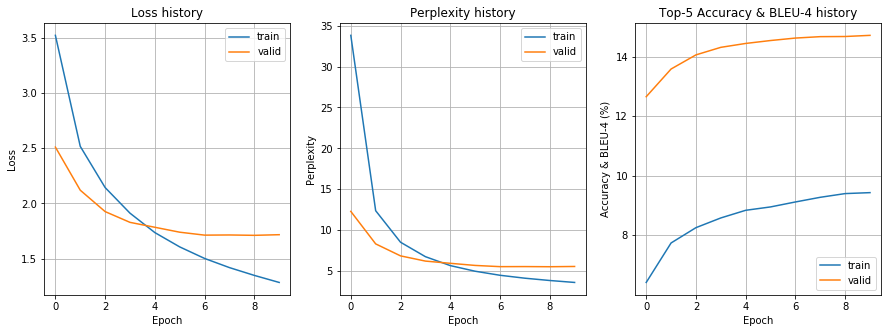

In [75]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['acc'], label='train')
axes[2].plot(history['val_acc'], label='valid')
axes[2].set_title('Top-5 Accuracy & BLEU-4 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy & BLEU-4 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

## Evaluation - Beam search & BLEU score

In [76]:
transformer.load_state_dict(torch.load('./checkpoints/transformer.pth'))
transformer.to(DEVICE)

Transformer(
  (encoder): EncoderLayer(
    (dropout): Dropout(p=0.25, inplace=False)
    (token_embedding): Embedding(7854, 256)
    (position_encoding): PositionalEncodingLayer()
    (encoder_block_layers): ModuleList(
      (0): EncoderBlockLayer(
        (dropout): Dropout(p=0.25, inplace=False)
        (multi_head_attention_layer): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
        )
        (multi_head_attention_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (position_wise_feed_forward_layer): PositionWiseFeedForwardLayer(
          (fc_in): Linear(in_features=256, out_features=512, bias=True)
          (fc_ou): Linear(in_features=512, out_features=256, bias=True)
        )
        (position

In [77]:
from beam_utils import Node, find_best_path, find_path

def evaluate(model, data, beam_size, src_field, dest_field, max_len, device):
    src_sentences = [*map(lambda example: example.src, data.examples)]
    dest_sentences = [*map(lambda example: example.trg, data.examples)]
    data = [*zip([*map(lambda word_list: src_field.process([word_list]), src_sentences)],
                 [*map(lambda word_list: dest_field.process([word_list]), dest_sentences)])]
    references, hypotheses, sources = [], [], []
    model.eval()
    with torch.no_grad():
        for i, (src_sequence, dest_sequence) in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence, dest_sequence = src_sequence.to(device), dest_sequence.to(device)
            src_mask = model.make_src_mask(src_sequence)
            src_encoded = model.encoder(src_sequences=src_sequence, src_mask=src_mask)
            # Decoding
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=None)]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    # Get tokens that're already translated
                    already_translated = torch.LongTensor([*map(lambda node: node.token, find_path(tree))][::-1]).unsqueeze(0).to(device)
                    dest_mask = model.make_dest_mask(already_translated)
                    logit, _ = model.decoder(dest_sequences=already_translated, src_encoded=src_encoded,
                                              dest_mask=dest_mask, src_mask=src_mask) # [1, dest_seq_len, vocab_size]                    
                    logp = F.log_softmax(logit[:, -1, :], dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps                    
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=None,
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True) # Sort next_nodes to get the best
                tree.append(next_nodes[:beam_size]) # Update the tree
            best_path = find_best_path(tree) # Find the best path of the tree

            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [dest_field.init_token, dest_field.eos_token], pred_translated[::-1])]

            hypotheses.append(pred_translated) # Update hypotheses

            # Update references
            references.append([[dest_field.vocab.itos[indice] for indice in dest_sequence[0] if indice not in (
                dest_field.vocab.stoi[dest_field.init_token],
                dest_field.vocab.stoi[dest_field.eos_token],
                dest_field.vocab.stoi[dest_field.pad_token]
            )]])

            # Update sources
            sources.append([src_field.vocab.itos[indice]  for indice in src_sequence[0] if indice not in (
                src_field.vocab.stoi[src_field.init_token],
                src_field.vocab.stoi[src_field.eos_token],
                src_field.vocab.stoi[src_field.pad_token]
            )])
    
        assert len(hypotheses) == len(references) == len(sources)
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25]) # Calculate BLEU-4 score
    return hypotheses, references, sources, bleu4

In [79]:
bleu_scores = []
for beam_size in [1, 3, 5]:
    for name, data in [('validation', valid_data), ('test', test_data)]:
        _, _, _, bleu4 = evaluate(model=transformer, data=data, beam_size=beam_size, src_field=DE, dest_field=EN, max_len=MAX_LEN, device=DEVICE)
        bleu_scores.append((beam_size, name, bleu4))
        
for score in bleu_scores:
    print(f'BLEU-4: {score[2]*100:.3f}% with beam_size={score[0]} on {score[1]} data')

100%|██████████| 1000/1000 [07:26<00:00,  2.24it/s]


BLEU-4: 35.858% with beam_size=1 on validation data
BLEU-4: 35.500% with beam_size=1 on test data
BLEU-4: 35.858% with beam_size=3 on validation data
BLEU-4: 35.500% with beam_size=3 on test data
BLEU-4: 35.858% with beam_size=5 on validation data
BLEU-4: 35.500% with beam_size=5 on test data


## Inference

In [81]:
def translate(sentences, model, beam_size, src_field, dest_field, max_len, device):
    if isinstance(sentences, list):
        sentences = [*map(src_field.preprocess, sentences)]
        targets = None
    if isinstance(sentences, Dataset):
        targets = [*map(lambda example: ' '.join(example.trg), sentences.examples)]
        sentences = [*map(lambda example: example.src, sentences.examples)]
    data = [*map(lambda word_list: src_field.process([word_list]), sentences)]
    translated_sentences, attention_weights, pred_logps = [], [], []
    model.eval()
    with torch.no_grad():
        for i, src_sequence in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence = src_sequence.to(device)
            src_mask = model.make_src_mask(src_sequence)
            src_encoded = model.encoder(src_sequences=src_sequence, src_mask=src_mask)
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=())]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    # Get tokens that're already translated
                    already_translated = torch.LongTensor([*map(lambda node: node.token, find_path(tree))][::-1]).unsqueeze(0).to(device)
                    dest_mask = model.make_dest_mask(already_translated)
                    logit, attn_weights = model.decoder(dest_sequences=already_translated, src_encoded=src_encoded,
                                              dest_mask=dest_mask, src_mask=src_mask) # [1, dest_seq_len, vocab_size]                      
                    logp = F.log_softmax(logit[:, -1, :], dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps                    
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=(attn_weights,),
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True)
                tree.append(next_nodes[:beam_size])
            best_path = find_best_path(tree)[::-1]
            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [
                dest_field.init_token, dest_field.eos_token
            ], pred_translated)]
            translated_sentences.append(' '.join(pred_translated))
            # Get probabilities
            pred_logps.append(sum([*map(lambda node: node.logps, best_path)]))
            # Get attention weights
            attention_weights.append(best_path[-1].states[0].cpu().numpy())
        sentences = [*map(lambda sentence: ' '.join(sentence), sentences)]
    return sentences, translated_sentences, targets, attention_weights, pred_logps

In [84]:
sentences, translated_sentences, dest_sentences, attention_weights, pred_logps = translate(sentences=test_data, model=transformer, beam_size=1, src_field=DE,
                                                                                           dest_field=EN, max_len=MAX_LEN, device=DEVICE)

100%|██████████| 1000/1000 [01:30<00:00, 11.09it/s]


In [92]:
def plot_attention(src, trg, scores, n_heads):
    fig = plt.figure(figsize=(15, 25))
    n_rows, n_cols = n_heads // 2, 2
    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        heatmap = ax.pcolor(scores[i], cmap='bone')

        ax.set_xticklabels(['<sos>'] + src.split() + ['<eos>'], minor=False, rotation='vertical')
        ax.set_yticklabels(trg.split() + ['<eos>'], minor=False)

        # put the major ticks at the middle of each cell
        # and the x-ticks on top
        ax.xaxis.tick_top()
        ax.set_xticks(np.arange(scores[i].shape[1]) + 0.5, minor=False)
        ax.set_yticks(np.arange(scores[i].shape[0]) + 0.5, minor=False)
        ax.invert_yaxis()

        plt.colorbar(heatmap)
    plt.show()

[ 26 625 268 661 534 770  64 151 848 838]



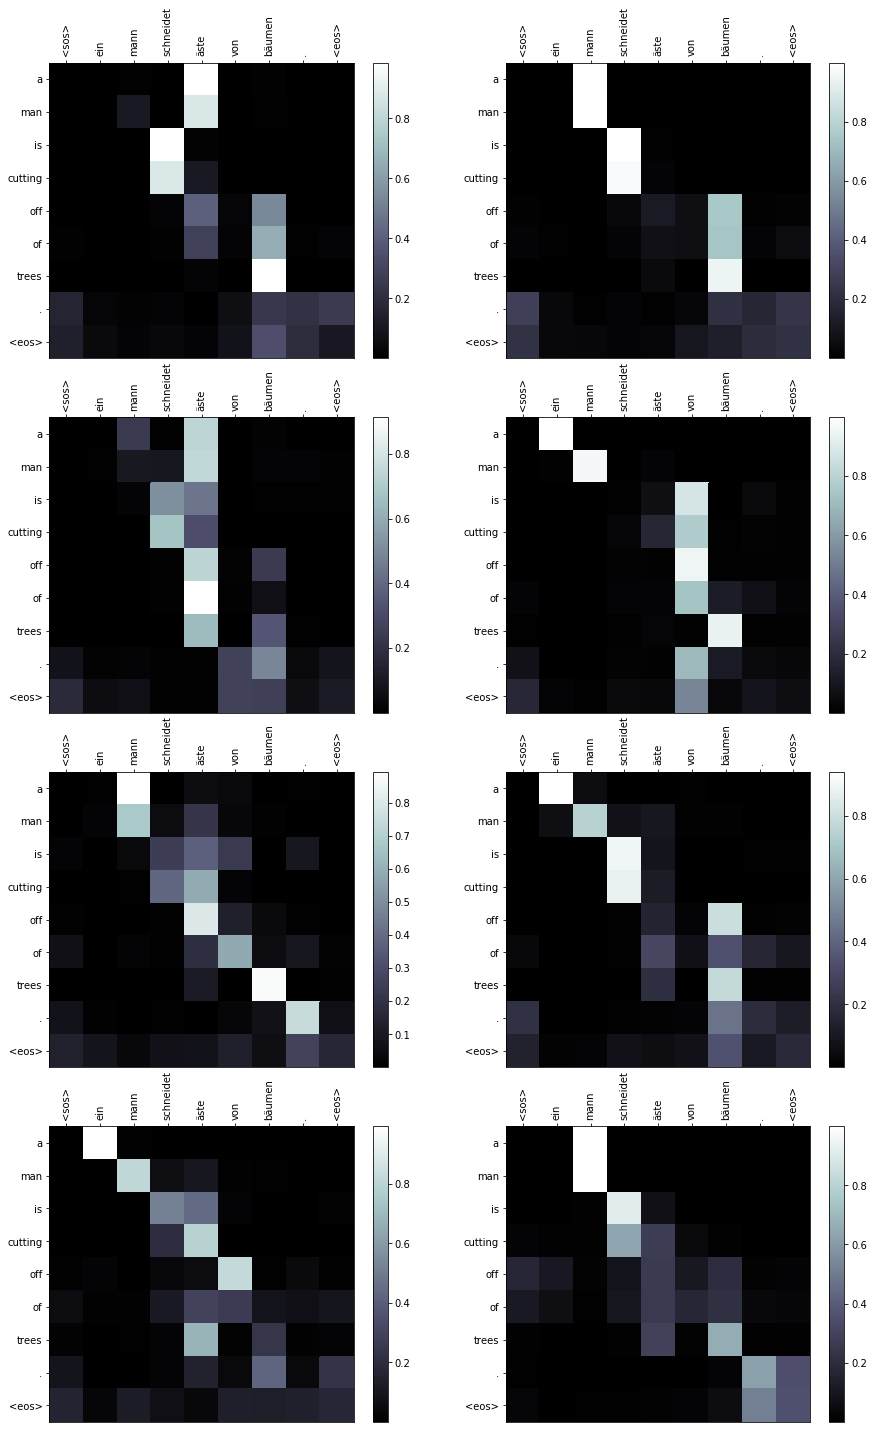

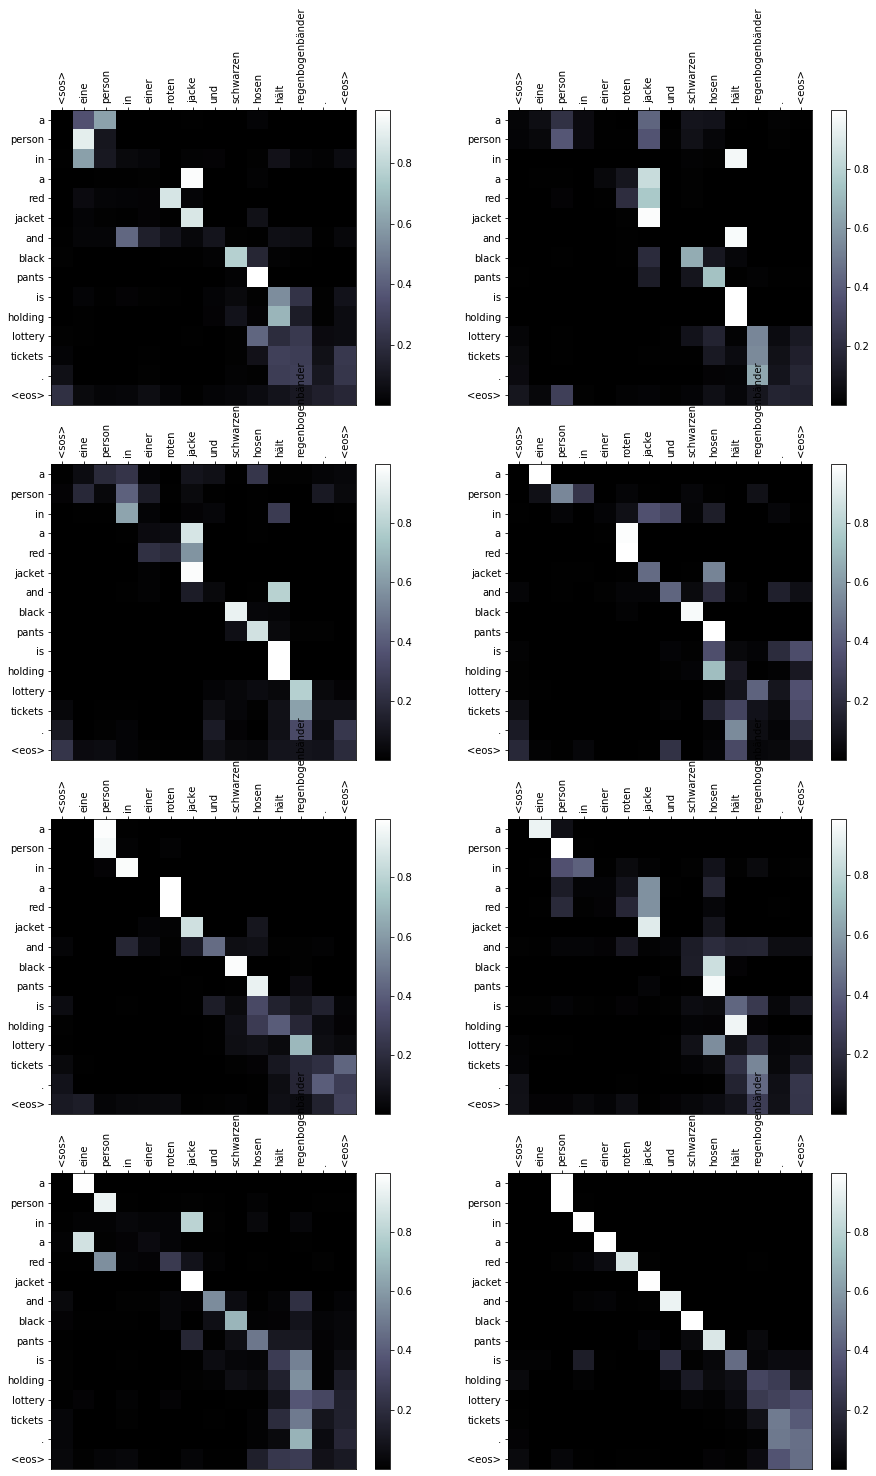

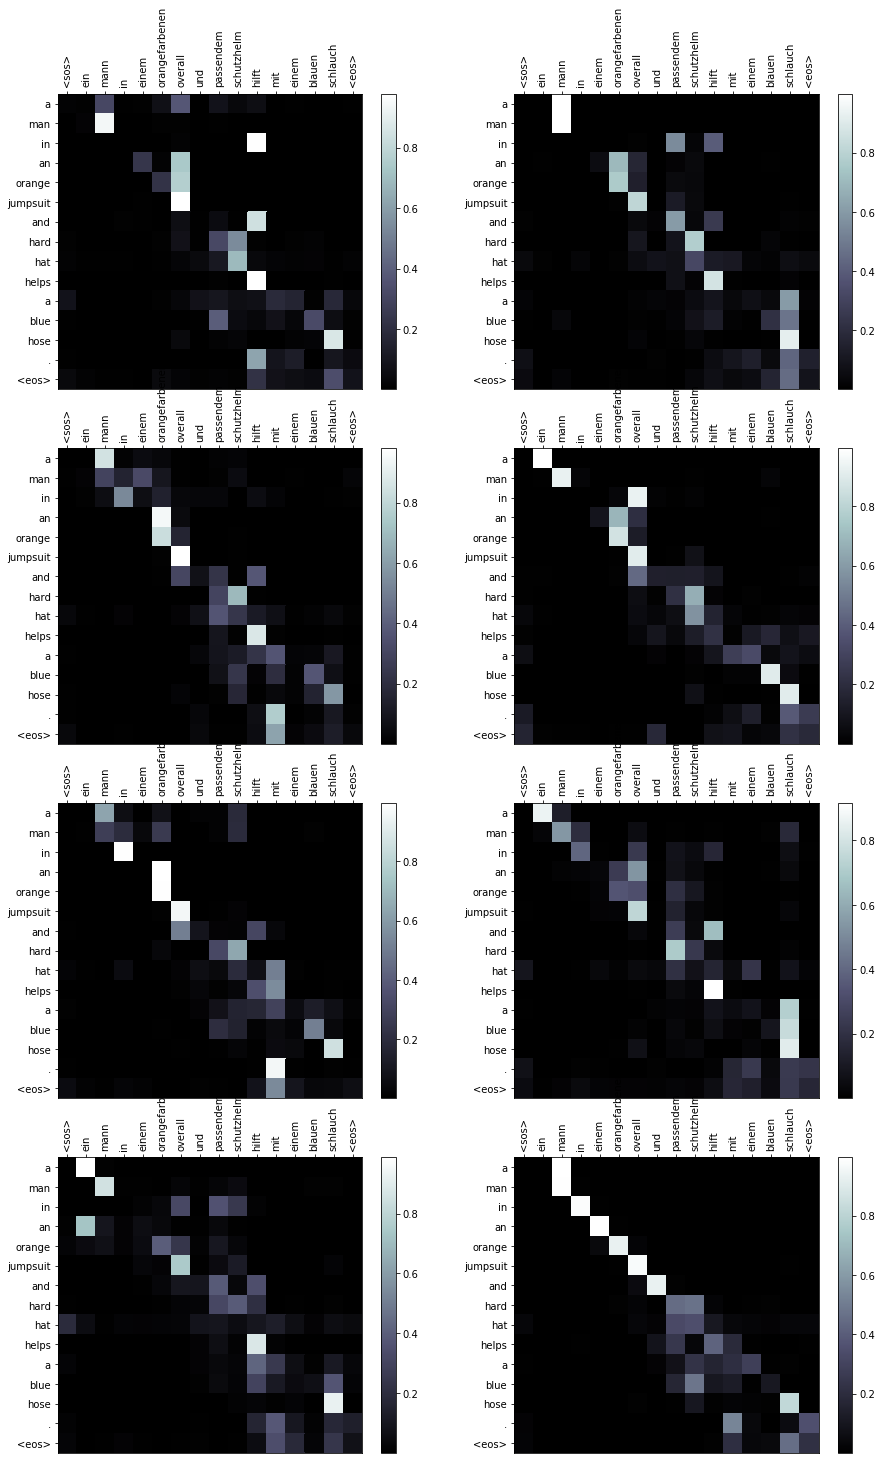

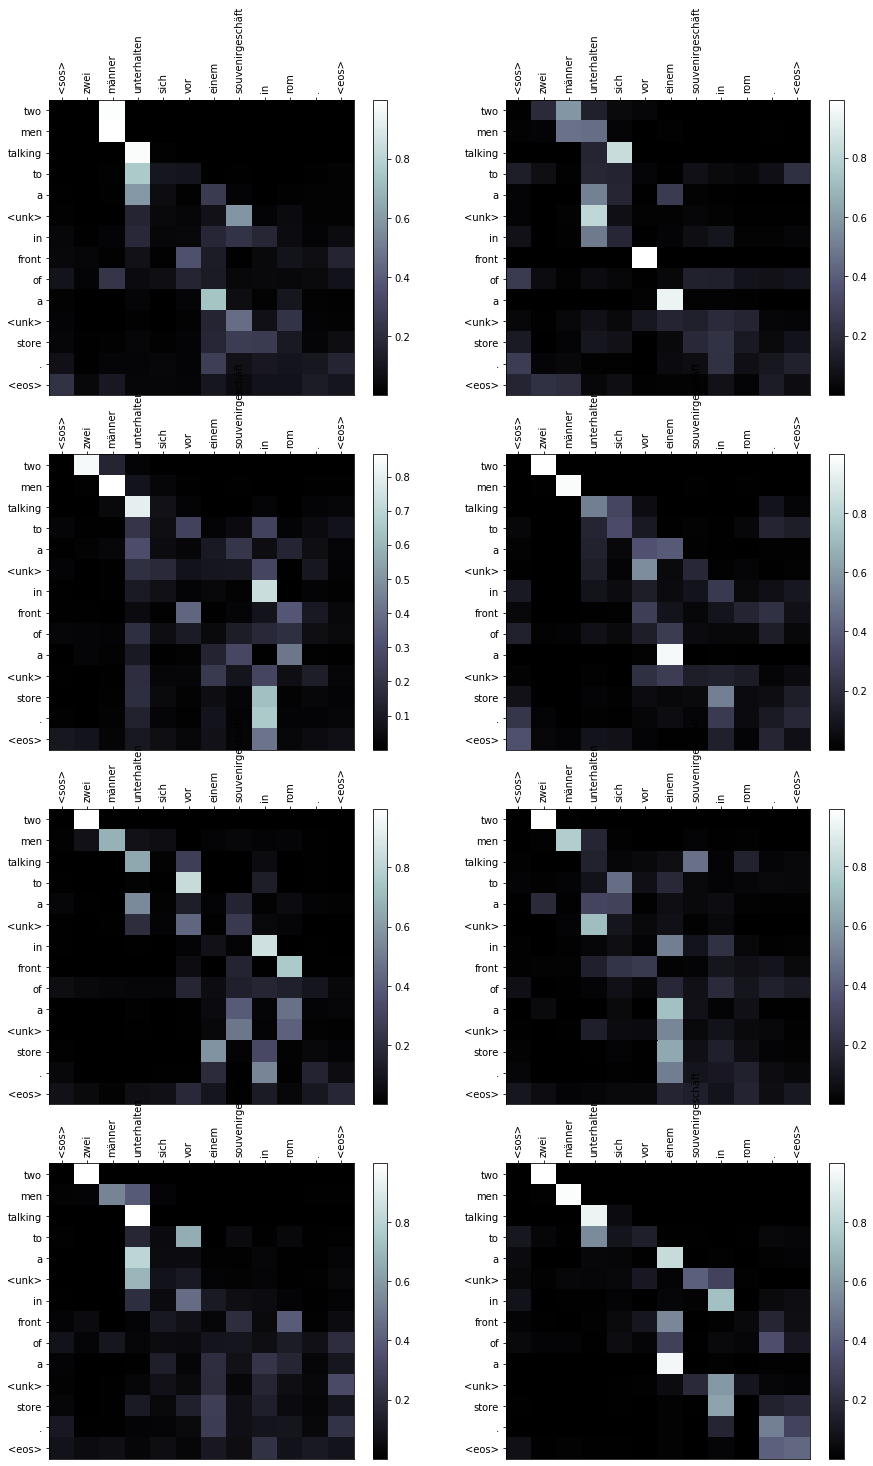

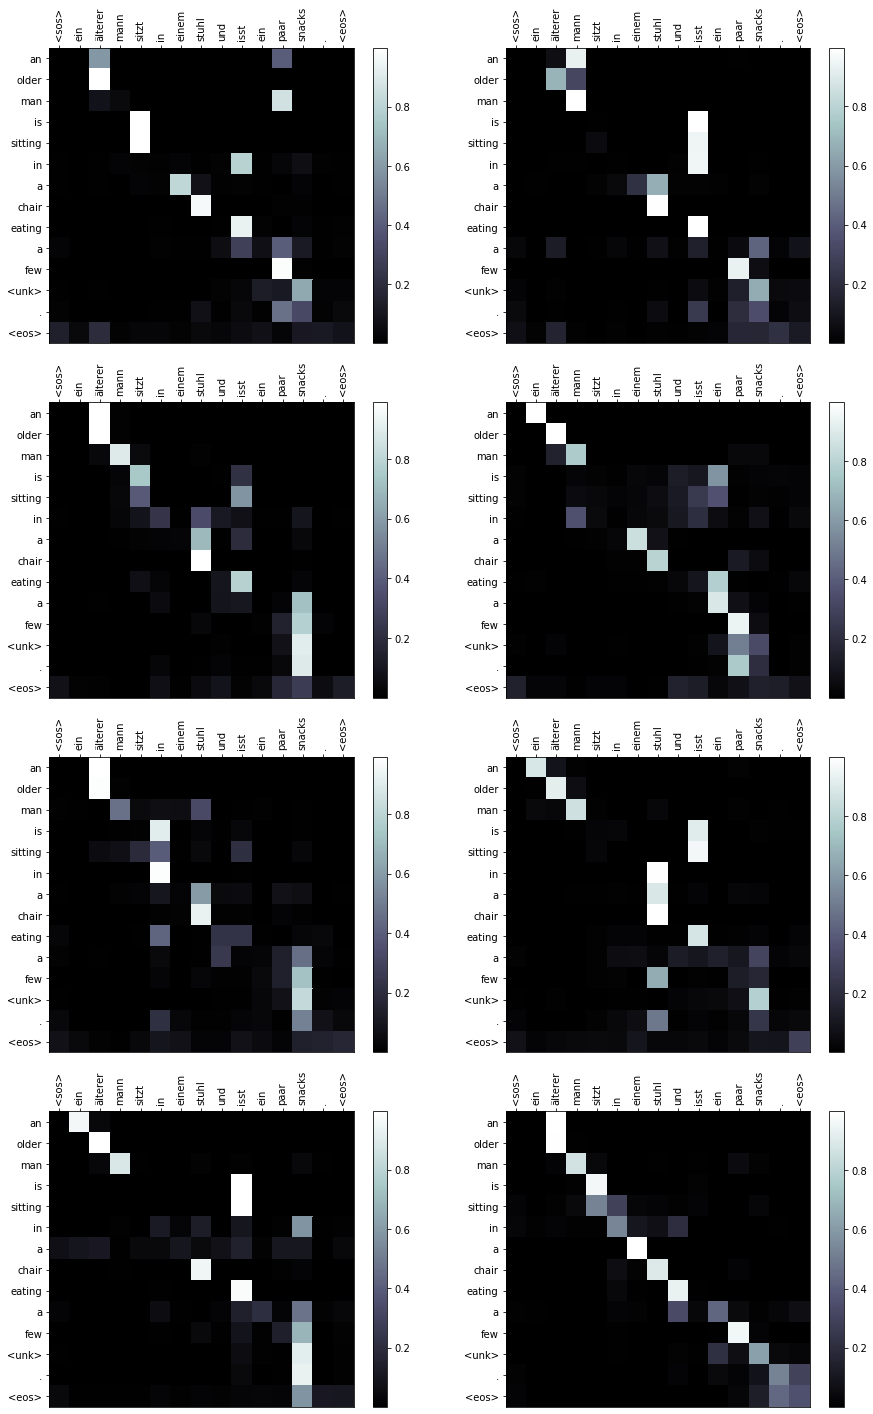

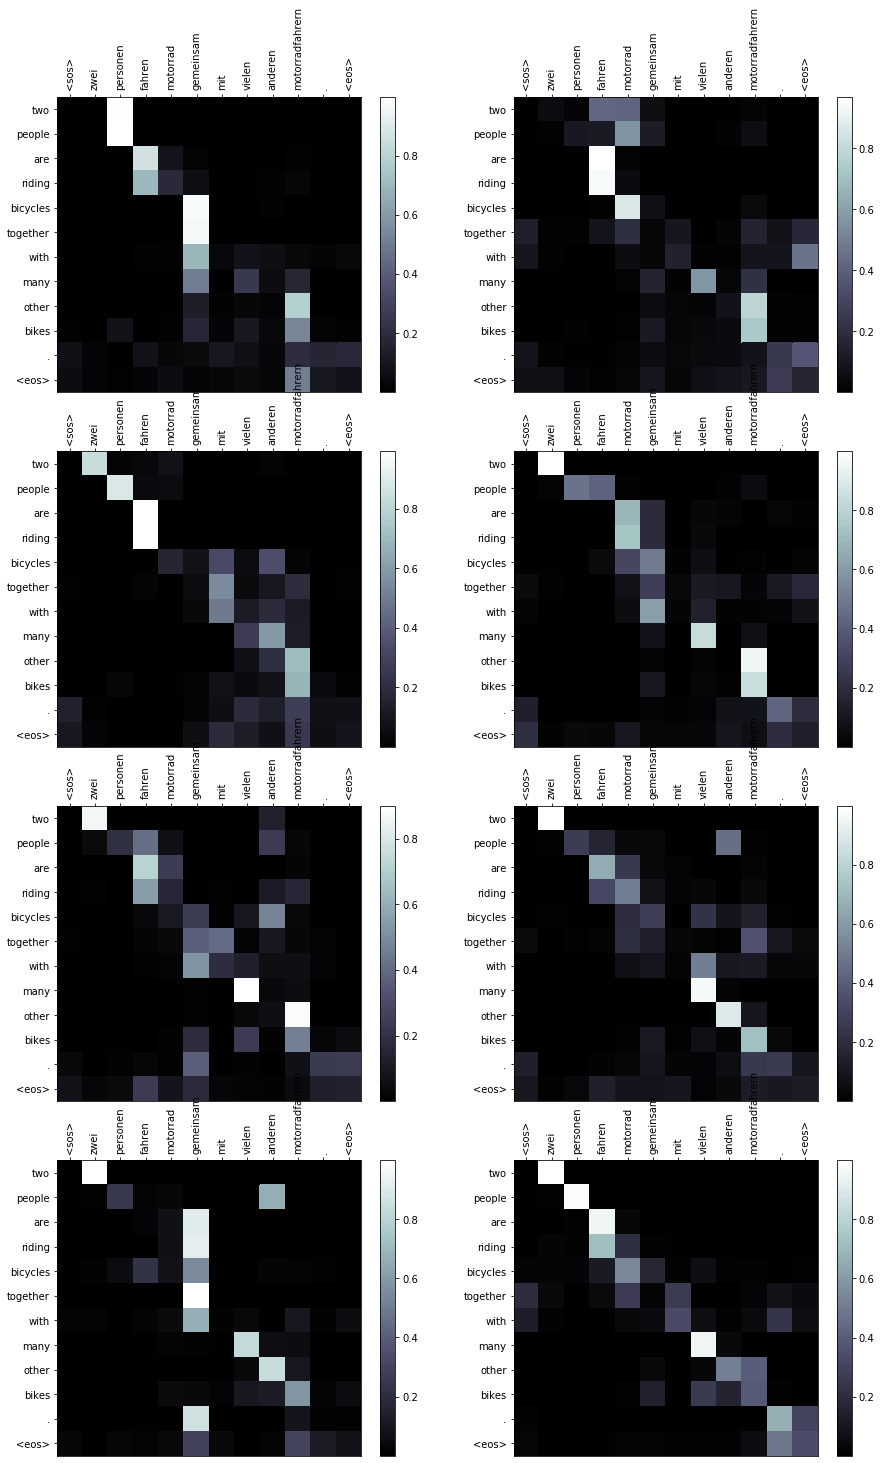

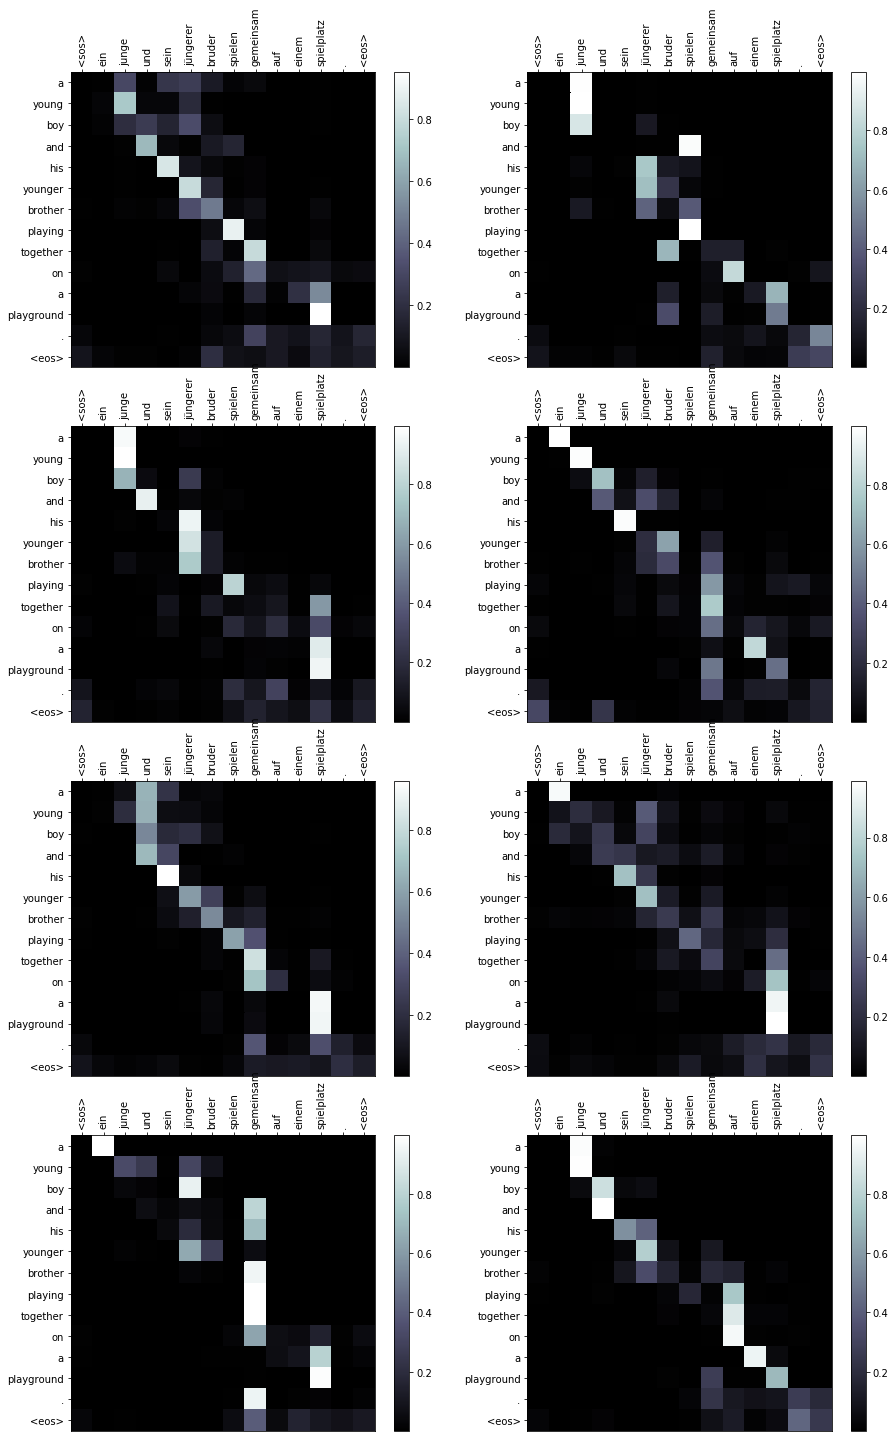

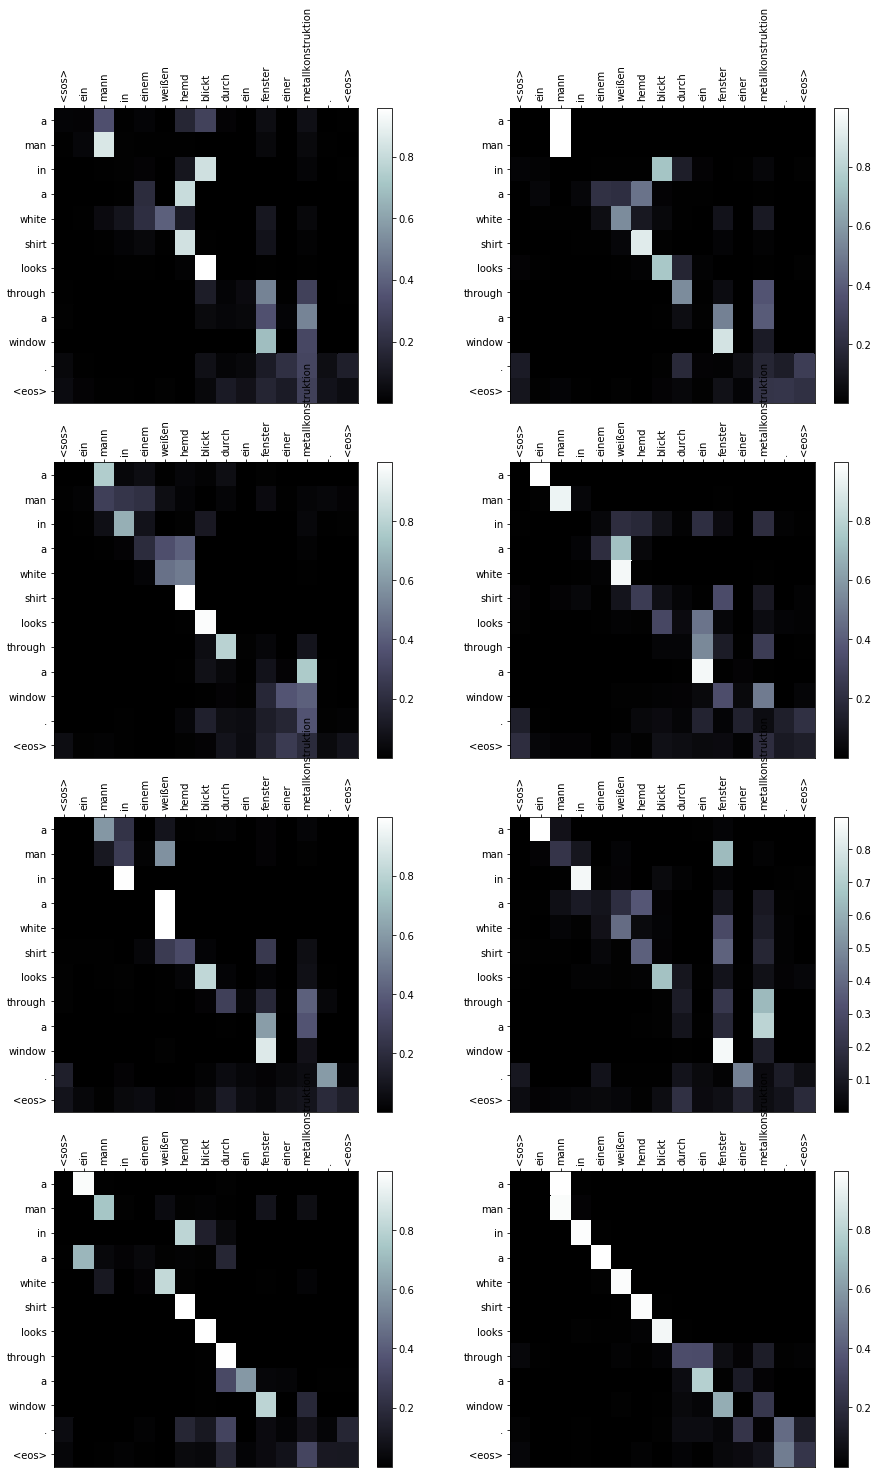

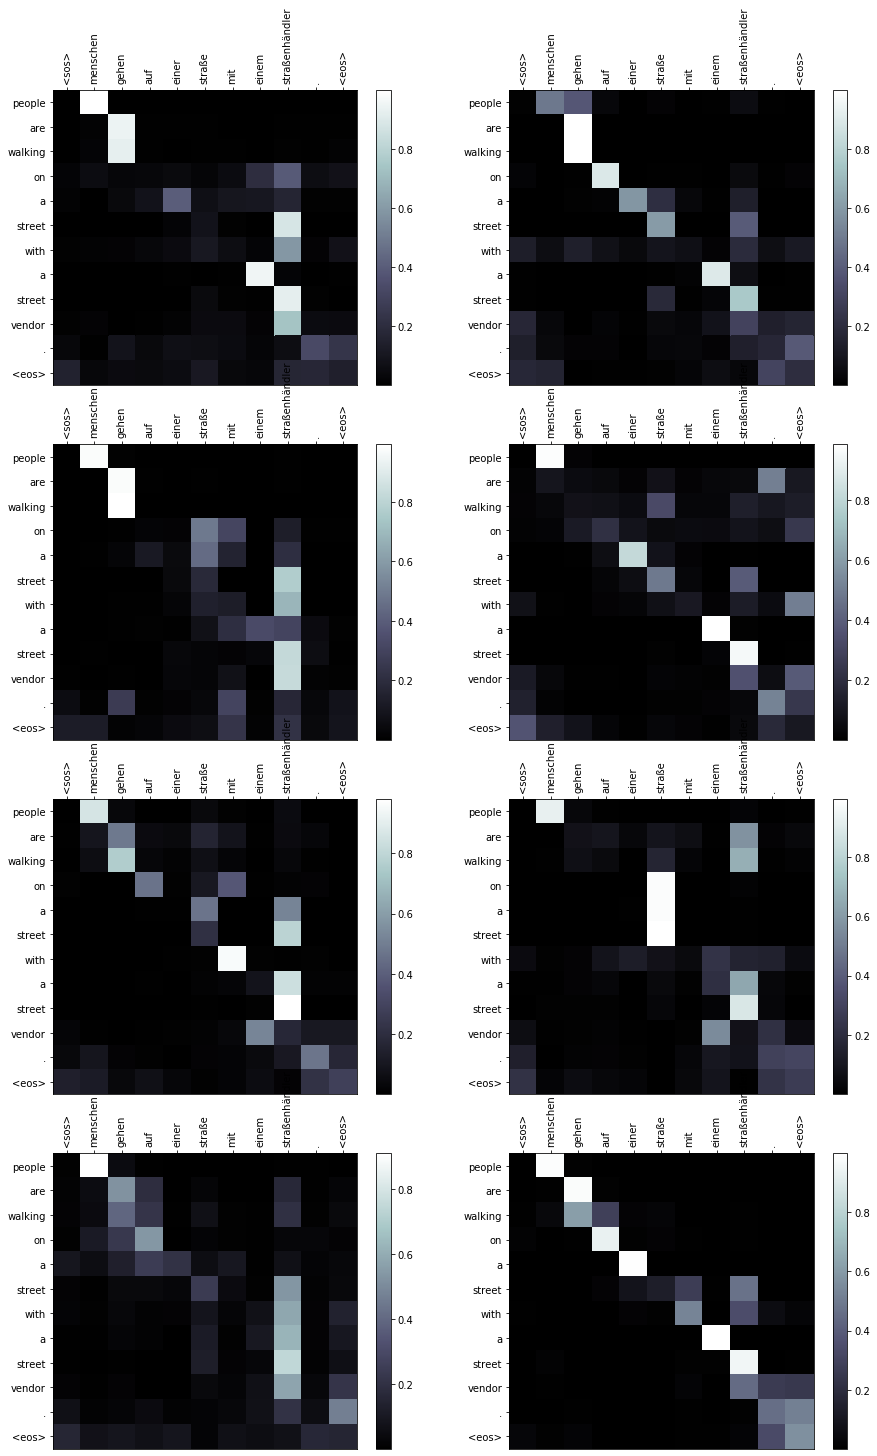

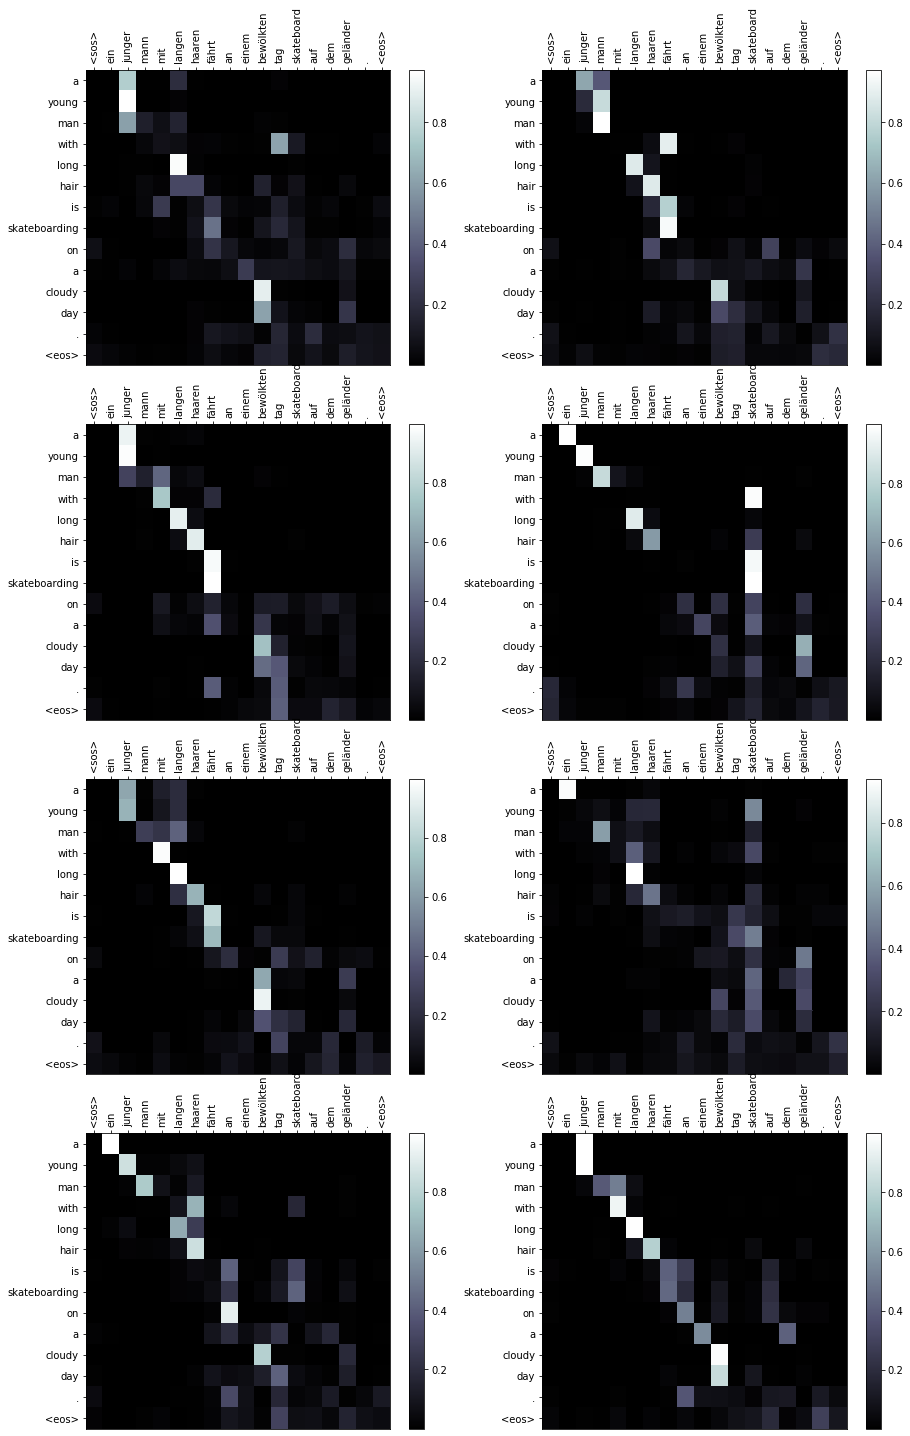

In [94]:
indexes = np.random.choice(len(test_data.examples), size=10, replace=False)
print(indexes)
print()
for i in indexes:
    html = f'<p><span style="color:blue"><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:red"><b>Predicted translation:</b> {translated_sentences[i]}</span></p>'
    display(HTML(html))
    plot_attention(sentences[i], translated_sentences[i], attention_weights[i][0], N_HEADS)
    print('='*100)

## Error Analysis

In [97]:
def get_dest_logp(model, data, src_field, dest_field, device):
    dest_logps = []
    model.eval()
    with torch.no_grad():
        for i, data in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence, dest_sequence = src_field.process([data.src]), dest_field.process([data.trg])
            src_sequence, dest_sequence = src_sequence.to(device), dest_sequence.to(device)
            src_mask = model.make_src_mask(src_sequence)
            src_encoded = model.encoder(src_sequences=src_sequence, src_mask=src_mask)                    
            logps = []
            for idx in range(dest_sequence.shape[0]):
                dest_mask = model.make_src_mask(dest_sequence[:, :idx+1])
                logit, _ = model.decoder(dest_sequences=dest_sequence[:, :idx+1], src_encoded=src_encoded, dest_mask=dest_mask, src_mask=src_mask)
                logp = F.log_softmax(logit[:, -1, :], dim=1).squeeze(dim=0)
                logps.append(logp[-1].cpu().item()) # Get logp of ground truth ouput
            dest_logps.append(sum(logps))
    return dest_logps

In [98]:
dest_logps = get_dest_logp(model=transformer, data=test_data, src_field=DE, dest_field=EN, device=DEVICE)
assert len(pred_logps) == len(dest_logps) == len(test_data), f'{len(pred_logps)}, {len(dest_logps)}, {len(test_data)}'

100%|██████████| 1000/1000 [00:08<00:00, 112.57it/s]


In [99]:
beam_search_faults = np.array(dest_logps) > np.array(pred_logps)

beam_search_fault_rate = beam_search_faults.sum() / beam_search_faults.size
print(f'Beam search fault rate: {beam_search_fault_rate * 100:.3f}%')
print(f'Model fault rate: {(1 - beam_search_fault_rate) * 100:.3f}%')

Beam search fault rate: 63.400%
Model fault rate: 36.600%


In [100]:
beam_search_fault_indexes = np.where(beam_search_faults == True)[0]
model_fault_indexes = np.where(beam_search_faults == False)[0]

In [101]:
for i in np.random.choice(beam_search_fault_indexes, size=5, replace=False):
    html = f'<p><span><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:red"><b>Predicted translation (Beam search fault):</b> {translated_sentences[i]}</span><br />'
    display(HTML(html))
    print('='*100)

In [102]:
for i in np.random.choice(model_fault_indexes, size=5, replace=False):
    html = f'<p><span><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:blue"><b>Predicted translation (Model fault):</b> {translated_sentences[i]}</span><br />'
    display(HTML(html))
    print('='*100)

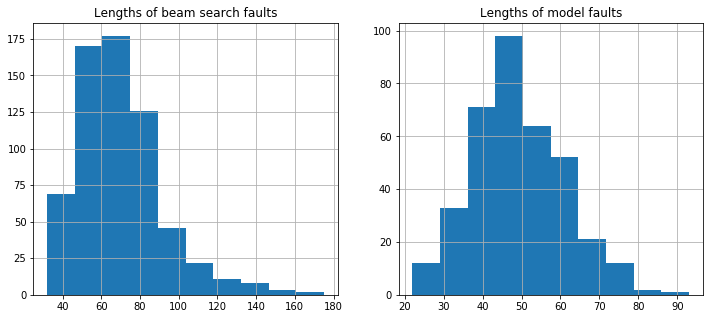

In [103]:
lengths = np.array([*map(len, dest_sentences)])

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(lengths[beam_search_fault_indexes])
axes[0].set_title('Lengths of beam search faults')
axes[0].grid(True)
axes[1].hist(lengths[model_fault_indexes])
axes[1].set_title('Lengths of model faults')
axes[1].grid(True)
plt.show()